# HW5 - Kaggle Competiton for Cancer Detection

by Adhir Uchil

Citations:  
Image reading: https://www.kaggle.com/code/dayivy/cnn-cancer-detection-kaggle-mini-project

Undersampling: https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets/notebook

VGG architecture: https://cs231n.github.io/convolutional-networks/

Optimizer choice: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

## 1) Problem Description

We are provided with 220025 images in the training folder and 57548 images in the test folder. We also have a csv file that provided labels for each of the 220025 training images.

In [8]:
import os
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Activation, MaxPooling2D, BatchNormalization, Dropout, Flatten

In [9]:
print(len(os.listdir('train')))
print(len(os.listdir('test')))

220025
57458


In [10]:
train_labels = pd.read_csv('train_labels.csv')
train_labels.shape

(220025, 2)

In [11]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


We can also confirm that each of the images has a dimension of (96 x 96 x 3)

In [12]:
rand_idx = random.randint(0, len(train_labels))
img_name = 'train/' + train_labels.iloc[rand_idx, 0] + '.tif'
random_image = mpimg.imread(img_name)
random_image.shape

(96, 96, 3)

## 2) Exploratory Data Analysis

Firstly, we can check some images with label 0 and label 1. As far as I can tell, there are no obvious differences between the two.

In [14]:
df_class_0 = train_labels[train_labels['label'] == 0]
df_class_1 = train_labels[train_labels['label'] == 1]

Images with label 0


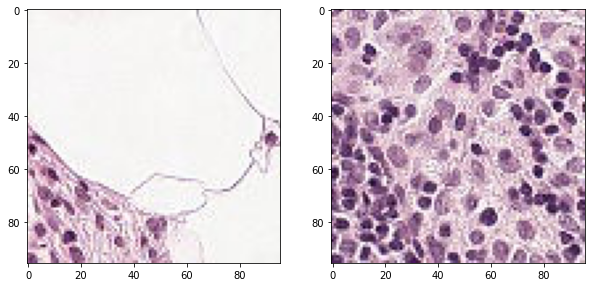

In [15]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))

print("Images with label 0")
img1 = mpimg.imread(f'train/{df_class_0.iloc[0, 0]}.tif')
img2 = mpimg.imread(f'train/{df_class_0.iloc[1, 0]}.tif')
ax = plt.subplot(1,2,1)
ax.imshow(img1)
ax = plt.subplot(1,2,2)
plt.imshow(img2);

Images with label 1


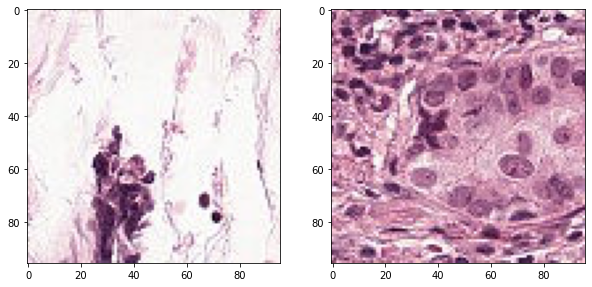

In [16]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))

print("Images with label 1")
img1 = mpimg.imread(f'train/{df_class_1.iloc[0, 0]}.tif')
img2 = mpimg.imread(f'train/{df_class_1.iloc[1, 0]}.tif')
ax = plt.subplot(1,2,1)
ax.imshow(img1)
ax = plt.subplot(1,2,2)
plt.imshow(img2);

From the `train_labels` file we can see that there are an uneven number of training data points labelled 0 and 1- we have 130908 images labelled 0 and 89117 images labelled 1.

In [17]:
train_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

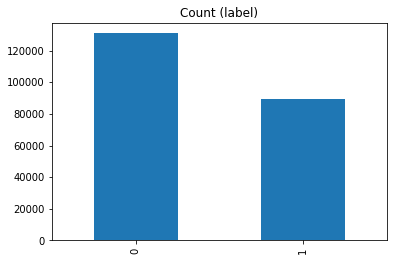

In [18]:
train_labels.label.value_counts().plot(kind='bar', title='Count (label)');

Since we have a large data set, we can use undersampling to balance out the data set.

Random Undersampling
0    89117
1    89117
Name: label, dtype: int64


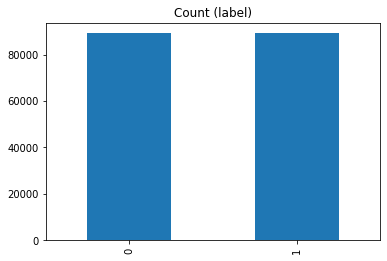

In [19]:
df_class_0_under = df_class_0.sample(len(df_class_1))
df_balanced = pd.concat([df_class_0_under, df_class_1], axis=0).reset_index(drop=True)

print('Random Undersampling')
print(df_balanced.label.value_counts())

df_balanced.label.value_counts().plot(kind='bar', title='Count (label)');

Next, we can split the data to a training and validation set in order to validate how well our model is doing and check for overfitting.

In [20]:
df_train, df_valid = train_test_split(df_balanced, test_size = 0.2, stratify=df_balanced.label)

Lastly, we will use the ImageDataGenerator class to read the images from the training folder and prepare them for processing.

In [21]:
df_train['label'] = df_train['label'].astype(str)
df_valid['label'] = df_valid['label'].astype(str)

In [22]:
df_train['id'] = df_train['id'] + '.tif'
df_valid['id'] = df_valid['id'] + '.tif'

In [23]:
train_datagen=ImageDataGenerator(rescale=1/255)

In [24]:
train_generator=train_datagen.flow_from_dataframe(dataframe=df_train, directory="train",
                x_col="id", y_col="label", batch_size=64, shuffle=True, class_mode="binary", target_size=(96,96))
valid_generator=train_datagen.flow_from_dataframe(dataframe=df_valid, directory="train",
                x_col="id", y_col="label", batch_size=64, shuffle=True, class_mode="binary", target_size=(96,96))

Found 142587 validated image filenames belonging to 2 classes.
Found 35647 validated image filenames belonging to 2 classes.


## 3) Model Architecture

I will be building a Convolutional Neural Network model for this data set because CNNs are very good at classifying images. This is because CNNs are able to identify common features among different images and use them as the basis of classification, rather than considering a pixel at a time as in the case of normal dense neural networks.

The architecture I will be using will be similar to the VGG architecture. Some of the features I will use are:

- Convolutional layers with 3x3 filters since research has shown that multiple layers of 3x3 filters are more effective than larger filters.

- Max pooling after a set of convolutional layers to gradually abstract the image and thus reduce computations and prevent overfitting.

- Batch normalizations after every max pool to standardize the input for the next convolutional layer.

- The classifier has three dense networks with 1000/4096/4096 nodes to predict the output.

- Rectified linear unit activation function for all intermediate layers since these provide a non-linear activation function that is computed quickly.

- Sigmoid activation function for the output layer since this is a binary classification problem

Due to time constraints, I will only be training the model for 10 epochs.

In [25]:
model = Sequential()
# First layer with 64 filters
model.add(Conv2D(64, (3, 3), padding='same',input_shape=(96,96,3), activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # size now 48 x 48
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # size now 24 x 24
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # size now 12 x 12
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # size now 6 x 6
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # size now 3 x 3
model.add(BatchNormalization())
          
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(1000, activation='relu'))


model.add(Dense(1, activation='sigmoid'))


In [26]:
opt = tf.keras.optimizers.Adam()

In [27]:
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 128)       1

In [28]:
epoch_history = model.fit(train_generator, validation_data=valid_generator, epochs=10)

Epoch 1/10
2228/2228 [==============================] - 487s 211ms/step - loss: 0.3733 - accuracy: 0.8454 - val_loss: 0.5241 - val_accuracy: 0.7657
Epoch 2/10
2228/2228 [==============================] - 460s 206ms/step - loss: 0.2317 - accuracy: 0.9096 - val_loss: 0.3460 - val_accuracy: 0.8749
Epoch 3/10
2228/2228 [==============================] - 466s 209ms/step - loss: 0.1939 - accuracy: 0.9261 - val_loss: 0.4995 - val_accuracy: 0.8110
Epoch 4/10
2228/2228 [==============================] - 451s 202ms/step - loss: 0.1670 - accuracy: 0.9373 - val_loss: 0.3930 - val_accuracy: 0.8650
Epoch 5/10
2228/2228 [==============================] - 438s 196ms/step - loss: 0.1471 - accuracy: 0.9455 - val_loss: 0.2591 - val_accuracy: 0.9128
Epoch 6/10
2228/2228 [==============================] - 445s 200ms/step - loss: 0.1270 - accuracy: 0.9532 - val_loss: 0.3074 - val_accuracy: 0.8998
Epoch 7/10
2228/2228 [==============================] - 447s 201ms/step - loss: 0.1094 - accuracy: 0.9609 - val_

## 4) Results

We can plot the training accuracy and the validation accuracy of the model to get an idea of how it trends with number of epochs. From the graph below, we can see that accuracy of both training and validation sets increase as the epochs progress, with neither having reached convergence yet. The validation accuracy is also not as volatile as I expected, possibly due to the regularization provided by the batch normalization layers.

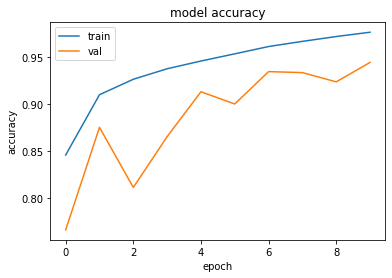

In [37]:
plt.plot(epoch_history.history['accuracy'])
plt.plot(epoch_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The high accuracy achieved by this model is a result of having many convolutional layers with a large number of filters. Previous attempts with a conservative number of filters (about 30 - 100) resulted in training accuracies of about 0.85 and much lower validation accuracies of about 0.7. 

Time and resource constraints prevented me from performing more hyperparameter tuning in order to identify the best architecture, activation functions and optimization metrics. In particular, I would have liked to try parametric rectified linear units as an activation function for the hidden layers and compared the accuracies obtained. 

## 5) Conclusion

The convolutional neural network trained over 10 epochs yielded a final training accuracy of 0.9761 and a validation accuracy of 0.9440. The test accuracy obtained by submitting the predictions to Kaggle was 0.8319.

The performance displayed by this model on a complex image data set was really impressive. In my first attempt, when using just a simple Artificial Neural Network to train the model, I was getting training accuracies of merely 0.5. CNNs were both able to provide a better predictive model but were also faster to train, thus proving to be the superior model for image classification tasks. 

In [30]:
test_files = os.listdir('test')
test_df = pd.DataFrame(test_files)
test_df.columns = ['id']
test_df.head()

,id
0,016b13f36a19b275e6ebf7b9747844a42ebe6901.tif
1,b5c4b0b4618c6a40bb8ce5e5f39c9d1475540fb3.tif
2,c923016b8eaa9929a760197ed072adfb0ae81746.tif
3,03a2de610ffe0284de4fbd46b73b6ce019f550a9.tif
4,6768d31e83b8c842c87a0acfee9a473d1c90b1d3.tif


In [31]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory="test", x_col="id",batch_size=64, shuffle=False,
                class_mode=None,target_size=(96,96))


Found 57458 validated image filenames.


In [32]:
predictions = model.predict(test_generator)

In [33]:
predictions[:5]

array([[0.00209597],
       [0.03280492],
       [0.99998677],
       [0.97684187],
       [0.00122253]], dtype=float32)

In [34]:
predictions = [1 if x > 0.5 else 0 for x in predictions]

In [35]:
submission = test_df.copy()
submission['id']=submission['id'].str[:-4]
submission['label']=predictions
submission.head()

,id,label
0,016b13f36a19b275e6ebf7b9747844a42ebe6901,0
1,b5c4b0b4618c6a40bb8ce5e5f39c9d1475540fb3,0
2,c923016b8eaa9929a760197ed072adfb0ae81746,1
3,03a2de610ffe0284de4fbd46b73b6ce019f550a9,1
4,6768d31e83b8c842c87a0acfee9a473d1c90b1d3,0


In [36]:
submission.to_csv('submission.csv',index=False)